# Model comparison
Natalia Vélez, March 2022

In [1]:
%matplotlib inline

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import seaborn as sns
import teaching_models as teach
from os.path import join as opj
from scipy.spatial import distance
from ast import literal_eval

sys.path.append('..')
from utils import read_json, gsearch, str_extract, int_extract, print_list

sns.set_style('white')
sns.set_context('talk')

Loading teaching problems
{'A': [[0, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 0, 0]],
 'B': [[1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]],
 'C': [[0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1, 1],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]],
 'D': [[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1]]}
Participants excluded from analysis:
[3, 17]
Cleaning up human behavioral data
    subject  run  block_idx  ex_idx first_movement   start  problem  \
0         1    1          0       0         [0, 1]  [0, 0]       22   
1         1    1          0       1         [0, 1]  [0, 0]       22   
3         1    1          1   

## Model recovery

Find model recovery files:

In [2]:
model_files = gsearch('outputs/simulated_model_comparison/*pxp.txt')
model_files.sort()
print_list(model_files)

Found 11 items
outputs/simulated_model_comparison/model-cost_pxp.txt
outputs/simulated_model_comparison/model-literal_cost_pxp.txt
outputs/simulated_model_comparison/model-literal_pref_cost_pxp.txt
outputs/simulated_model_comparison/model-literal_pref_pxp.txt
outputs/simulated_model_comparison/model-literal_pxp.txt
outputs/simulated_model_comparison/model-pragmatic_cost_pxp.txt
outputs/simulated_model_comparison/model-pragmatic_pref_cost_pxp.txt
outputs/simulated_model_comparison/model-pragmatic_pref_pxp.txt
outputs/simulated_model_comparison/model-pragmatic_pxp.txt
outputs/simulated_model_comparison/model-pref_cost_pxp.txt
...


Data wrangling

In [3]:
pxp_list = []
model_levels = ['pragmatic_pref_cost',  'pragmatic_pref',  'pragmatic_cost', 'pragmatic', 'literal_pref_cost', 'literal_pref',  'literal_cost', 'literal', 'pref_cost',  'pref', 'cost']
for f in model_files:
    pxp = np.loadtxt(f,delimiter=',')

    label_f = f.replace('pxp', 'model_labels')
    labels = np.loadtxt(label_f, dtype=str)

    f_df = pd.DataFrame(list(zip(labels, pxp)), columns=['fit_model', 'pxp'])
    f_df['true_model'] = str_extract('(?<=model-).+(?=_pxp)', f)
    
    pxp_list.append(f_df)
    
pxp_df = pd.concat(pxp_list)
pxp_df['fit_model'] = pxp_df.fit_model.astype('category').cat.reorder_categories(model_levels)
pxp_df['true_model'] = pxp_df.true_model.astype('category').cat.reorder_categories(model_levels)

print(pxp_df.shape)
pxp_df.head()

(121, 3)


,fit_model,pxp,true_model
0,cost,1.000000e+00,cost
1,literal,3.879920e-18,cost
2,literal_cost,3.879920e-18,cost
3,literal_pref,3.879920e-18,cost
4,literal_pref_cost,3.879920e-18,cost


Make confusion matrix

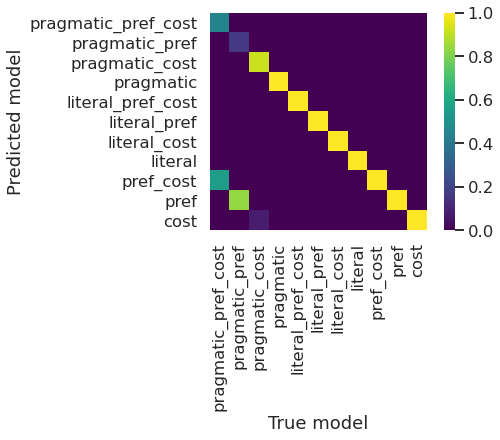

In [22]:
confusion_mtx = pxp_df.pivot(index='fit_model', columns='true_model', values='pxp')
ax = sns.heatmap(confusion_mtx, cmap='viridis', square=True)
ax.set(xlabel='True model', ylabel='Predicted model')
plt.savefig('plots/model_recovery.png', bbox_inches='tight')

## Model comparison: Which model best captures human behavior?

Read model evidence file:

In [5]:
human_pxp = np.loadtxt('outputs/human_model_comparison/human_model_pxp.txt', delimiter=',')
human_labels = np.loadtxt('outputs/human_model_comparison/model_labels.txt', dtype=str)

human_df = pd.DataFrame({'model': human_labels, 'pxp': human_pxp})
human_df['model'] = human_df['model'].astype('category').cat.reorder_categories(model_levels + ['strong'])
human_df = human_df.sort_values(by='model').reset_index(drop=True)

human_df

,model,pxp
0,pragmatic_pref_cost,2.644246e-20
1,pragmatic_pref,2.644246e-20
2,pragmatic_cost,2.644246e-20
3,pragmatic,2.644246e-20
4,literal_pref_cost,1.000000e+00
5,literal_pref,2.644246e-20
6,literal_cost,2.644246e-20
7,literal,2.644246e-20
8,pref_cost,2.644246e-20
9,pref,2.644246e-20


Read probability that each model generated each teacher:

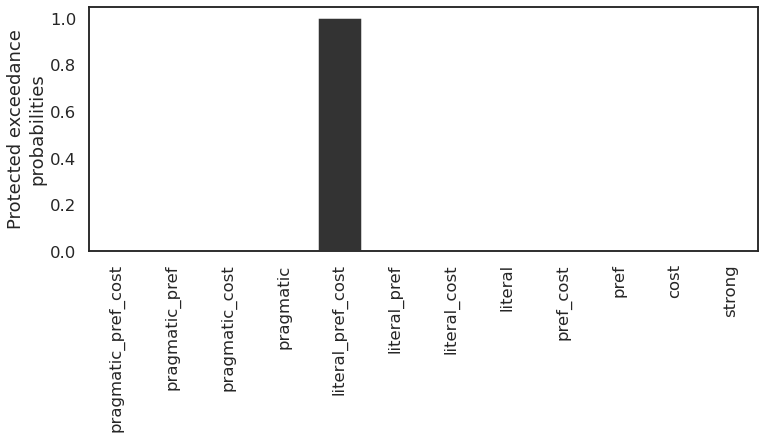

In [6]:
fig,ax=plt.subplots(figsize=(12,4.5))
sns.barplot(data=human_df, x='model', y='pxp', ax=ax, fc='#333')
ax.set(xlabel='', ylabel='Protected exceedance\nprobabilities')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.savefig('plots/model_comparison_results.pdf', bbox_inches='tight')

## Predictive checks: How well does the winning model capture qualitative patterns in human behavior?

Helper function: Return frequency of responses as a 6x6 matrix for plotting

In [7]:
def example_matrix(group):
    freq = np.zeros(36)
    freq[group.example] = group.freq
    freq_mtx = np.reshape(freq, (6,6))
    
    return freq_mtx

Find simulation files

In [8]:
sim_files = gsearch('outputs', 'simulated_from_human', '*pref_cost.csv')
sim_files.sort()

print_list(sim_files)

Found 3 items
outputs/simulated_from_human/simulated_data_model-literal_pref_cost.csv
outputs/simulated_from_human/simulated_data_model-pragmatic_pref_cost.csv
outputs/simulated_from_human/simulated_data_model-pref_cost.csv


Wrangle simulation data

In [9]:
sim_df = pd.concat([pd.read_csv(f) for f in sim_files])

print(sim_df.shape)
sim_df.head()

(10080, 7)


,weight,niter,problem,cursor,example,subject,model
0,[1.8281781056515283 27.023672591472838 3.09996...,0,0,5,10,sub-01,literal_pref_cost
1,[1.8281781056515283 27.023672591472838 3.09996...,0,0,10,7,sub-01,literal_pref_cost
2,[1.8281781056515283 27.023672591472838 3.09996...,0,0,7,33,sub-01,literal_pref_cost
3,[1.8281781056515283 27.023672591472838 3.09996...,0,1,0,13,sub-01,literal_pref_cost
4,[1.8281781056515283 27.023672591472838 3.09996...,0,1,13,25,sub-01,literal_pref_cost


Plot average simulation results against human data

In [16]:
def predictive_check(prob_idx):
    # Mask plots using true hypothesis
    prob = teach.problems[prob_idx]
    mask = 1-np.array(prob['A'])

    # Average human responses
    prob_human = (
        teach.human_df
        [teach.human_df.problem == prob_idx]
        .copy()
        .groupby('example')
        .agg({'subject': 'count'})
        .reset_index()
        .rename(columns={'subject': 'n'})
    )
    prob_human['freq'] = prob_human.n/prob_human.n.sum()

    # Average simulated responses
    prob_sim = (
        sim_df[sim_df.problem == prob_idx]
        .copy()
        .groupby(['model', 'example'])
        .agg({'subject': 'count'})
        .reset_index()
        .rename(columns={'subject': 'n'})
    )
    prob_sim['n_total'] = prob_sim.groupby(['model']).n.transform('sum')
    prob_sim['freq'] = prob_sim.n/prob_sim.n_total

    # Plot human data
    n_models = prob_sim.model.nunique()
    fig,axes = plt.subplots(1,n_models+1, figsize=(4*(n_models+1)*1.25, 4))
    human_mtx = example_matrix(prob_human)
    sns.heatmap(human_mtx, cmap='viridis', square=True, ax=axes[0], mask=mask, lw=2, linecolor='#fff')
    axes[0].set(title='Human', xticklabels=[], yticklabels=[])

    # Plot simulated data
    ax_counter = 1
    for name, group in prob_sim.groupby('model'):
        freq_mtx = example_matrix(group)
        sns.heatmap(freq_mtx, cmap='viridis', square=True, ax=axes[ax_counter], mask=mask, lw=1, linecolor='#fff')
        axes[ax_counter].set(title=name, xticklabels=[], yticklabels=[])

        ax_counter += 1

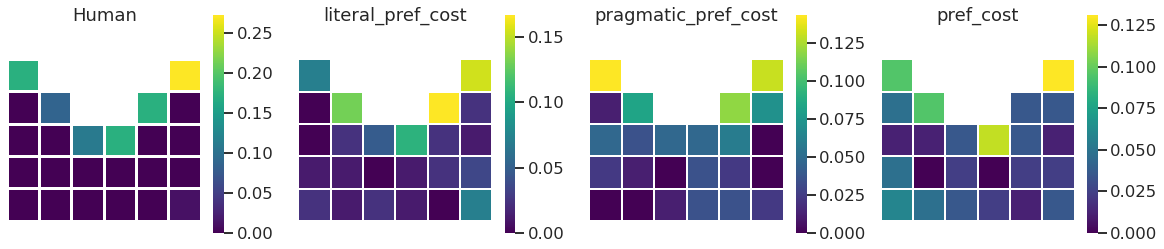

In [19]:
#_ = teach.plot_problem(3)
predictive_check(3)
plt.savefig('plots/predictive_check.png')

And here's a counterexample where the pragmatic model does particularly well:

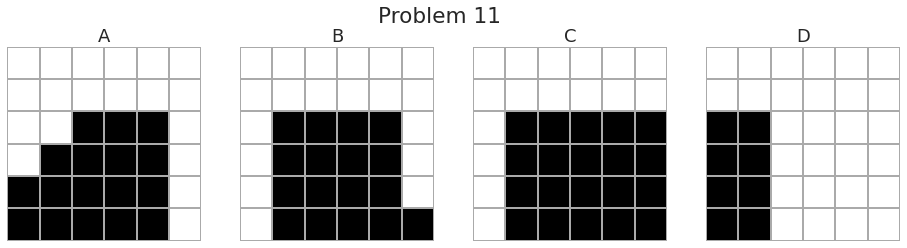

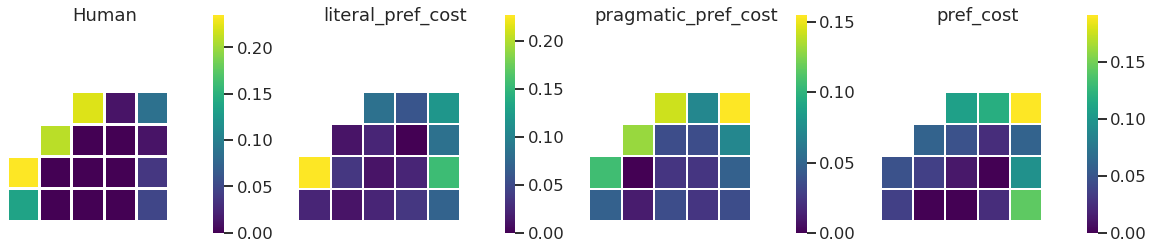

In [18]:
_ = teach.plot_problem(11)
predictive_check(11)

## Sanity check: Plot idealized model predictions

Informational value

<ipython-input-14-68d3f3c1fba0>:5: RuntimeWarning: divide by zero encountered in log
  info_value = np.log(pH)
/n/helmod/apps/centos7/Core/Anaconda3/2020.11-jupyterood-fasrc01/x/lib/python3.8/site-packages/matplotlib/colors.py:1062: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


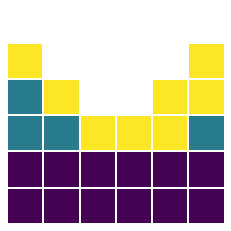

In [14]:
prob = teach.problems[3]
prob_mask = 1-np.array(prob['A'])

pD,pH = teach.strong_sampling(3)
info_value = np.log(pH)
info_mtx = teach.sampling_matrix(info_value)

ax = sns.heatmap(info_mtx, square=True, cbar=False, cmap='viridis', lw=1, linecolor='#fff', mask=prob_mask)
ax.set(xticklabels=[], yticklabels=[])

plt.savefig('plots/info_value.png')

Edge preference:

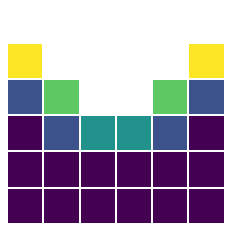

In [34]:
prob = teach.problems[3]
prob_mask = 1-np.array(prob['A'])

edge_df = teach.edge_pref(prob)
edge_mtx = teach.sampling_matrix(edge_df)
ax = sns.heatmap(edge_mtx, square=True, cbar=False, cmap='viridis', lw=1, linecolor='#fff', mask=prob_mask)
ax.set(xticklabels=[], yticklabels=[])

plt.savefig('plots/edge_pref.png')

Distance:

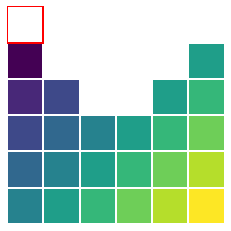

In [19]:
cost_df = teach.movement_cost(3)
cost_mtx = teach.sampling_matrix(cost_df)

ax = sns.heatmap(cost_mtx, square=True, cbar=False, cmap='viridis', lw=1, linecolor='#fff', mask=prob_mask)
ax.set(xticklabels=[], yticklabels=[])
ax.add_patch(Rectangle((0, 0), 1.0, 1.0, edgecolor='red', fill=False, lw=2))

plt.savefig('plots/distance.png')

Utility:

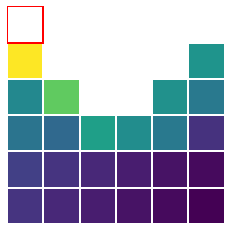

In [27]:
pD, pH = teach.utility_sampling(3, sampling_fun=teach.strong_sampling, pref_fun=teach.edge_pref)
utility_mtx = teach.sampling_matrix(pD)

ax = sns.heatmap(utility_mtx, square=True, cbar=False, cmap='viridis', lw=1, linecolor='#fff', mask=prob_mask)
ax.set(xticklabels=[], yticklabels=[])
ax.add_patch(Rectangle((0, 0), 1.0, 1.0, edgecolor='red', fill=False, lw=2))

plt.savefig('plots/utility.png')